# Gradient Descent

Exploring empirical behavior of gradient descent during training. Some questions of interest are:


- how big is a step?

    - per layer, per neuron, entire network?
    - how does it change over the course of training?
- what do good starting initializations look like?
-  where does the network end up
?
	- ie, how much do the parameters actually shift?

In [14]:
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Generator

import pandas as pd

In [2]:
# run exploration notebook to get classes -- in the future, might be worth a more elegant solution, like putting custom classes into a distinct .py file

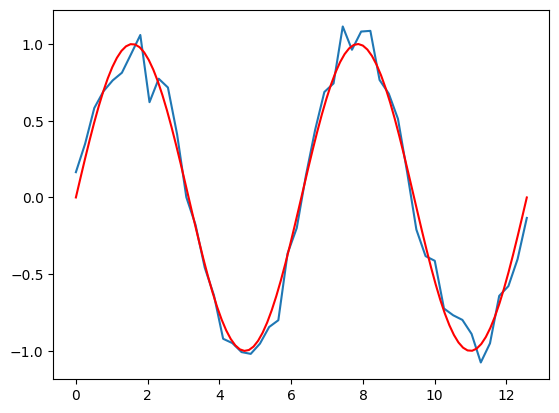

Epoch: 1


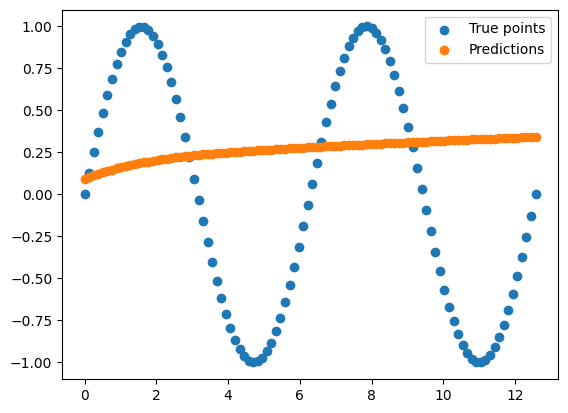

Avg loss: 0.603679 

Epoch: 2


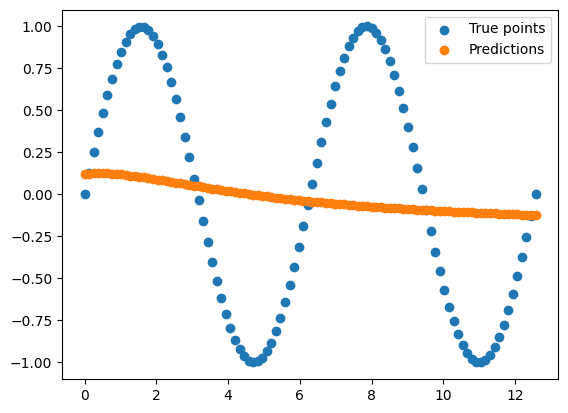

Avg loss: 0.457577 

Epoch: 3


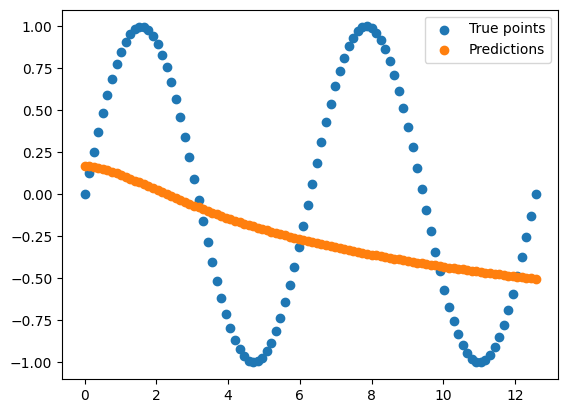

Avg loss: 0.477179 

Epoch: 4


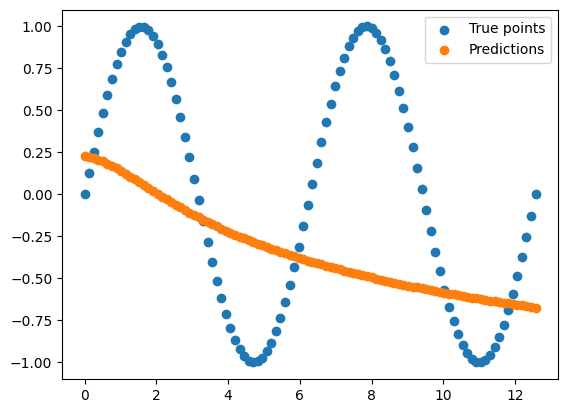

Avg loss: 0.524824 

Epoch: 5


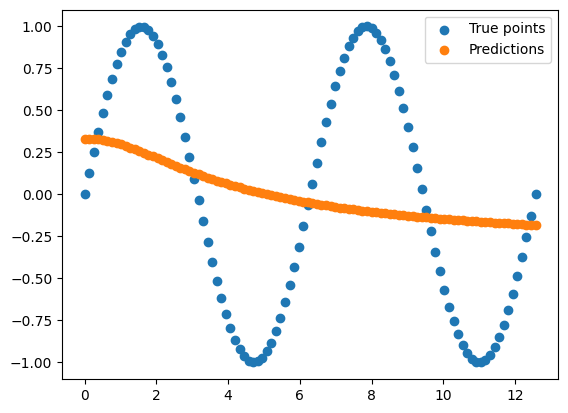

Avg loss: 0.430049 

Epoch: 6


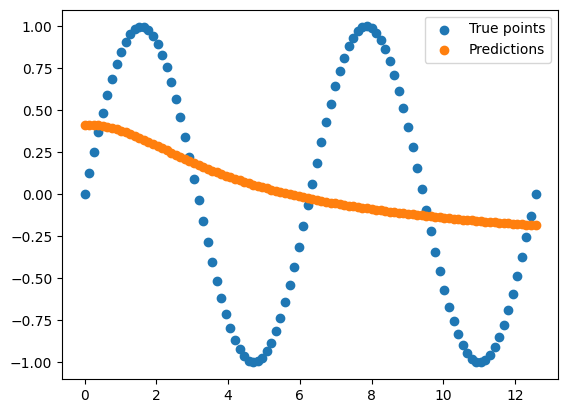

Avg loss: 0.425626 

Epoch: 7


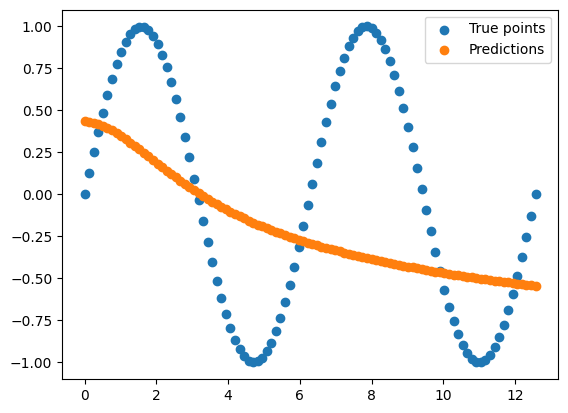

Avg loss: 0.451953 

Epoch: 8


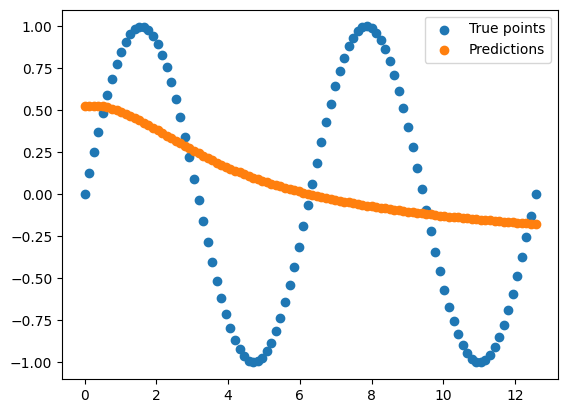

Avg loss: 0.424734 

Epoch: 9


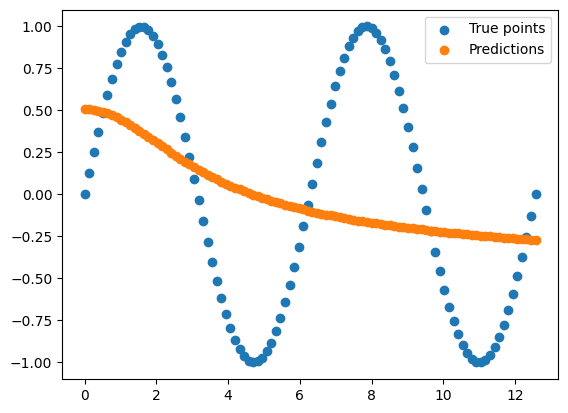

Avg loss: 0.414875 

Epoch: 10


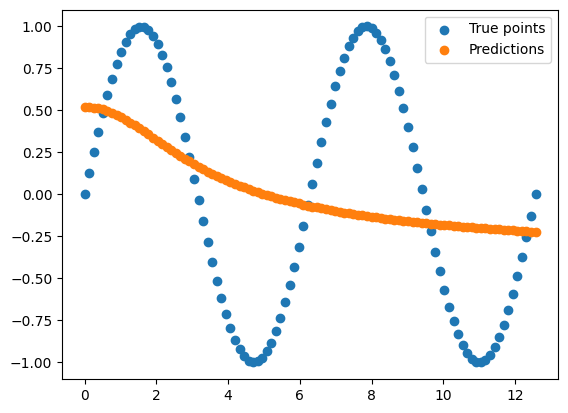

Avg loss: 0.415795 

Epoch: 11


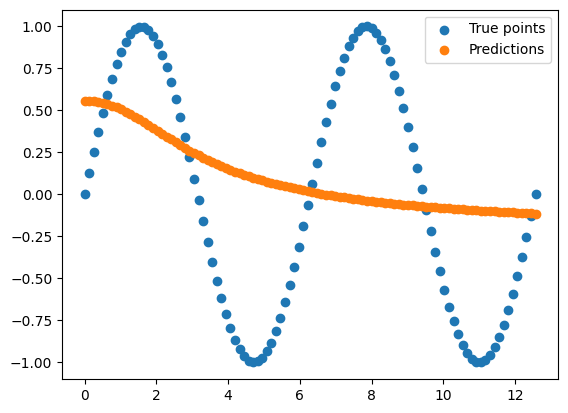

Avg loss: 0.428060 

Epoch: 12


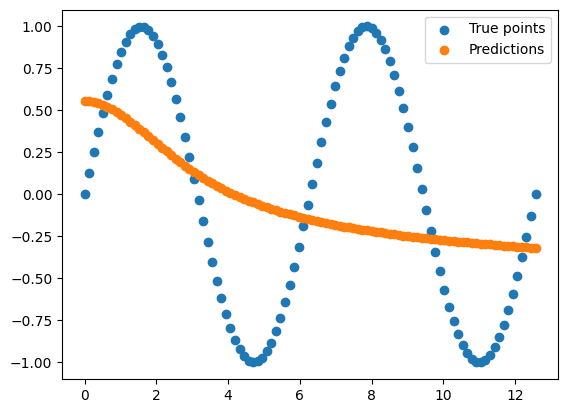

Avg loss: 0.412922 

Epoch: 13


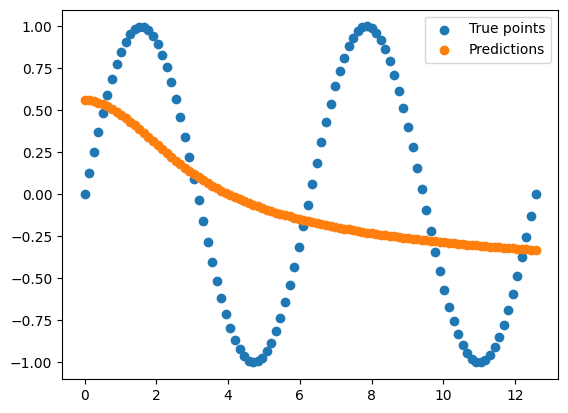

Avg loss: 0.413134 

Epoch: 14


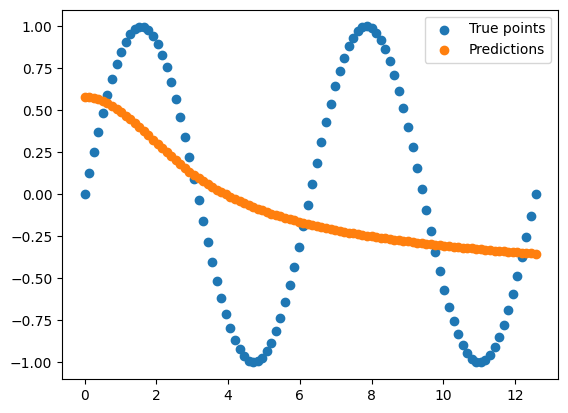

Avg loss: 0.413514 

Epoch: 15


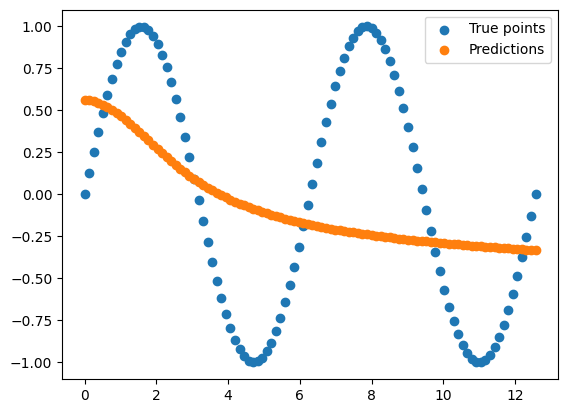

Avg loss: 0.413685 

Epoch: 40


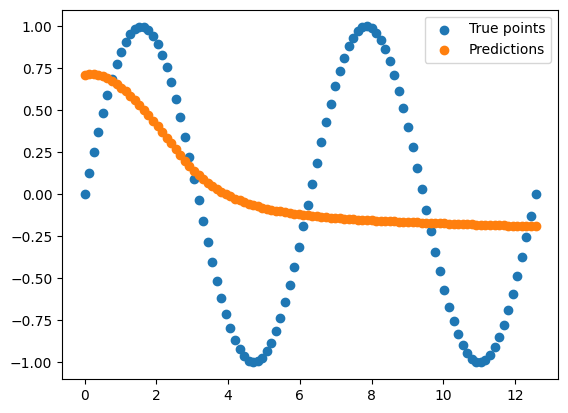

Avg loss: 0.397081 

Epoch: 80


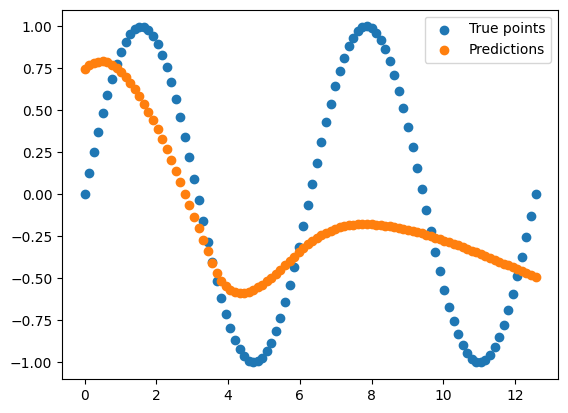

Avg loss: 0.302186 

Epoch: 120


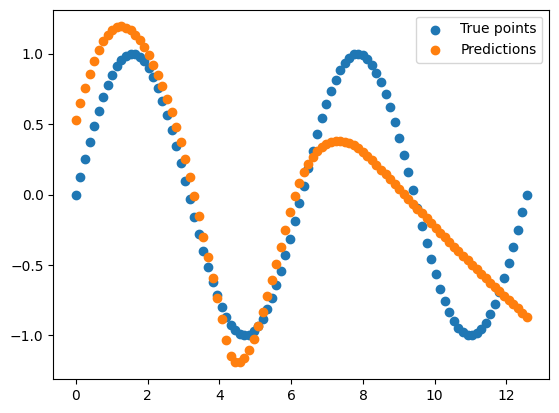

Avg loss: 0.127725 

Epoch: 160


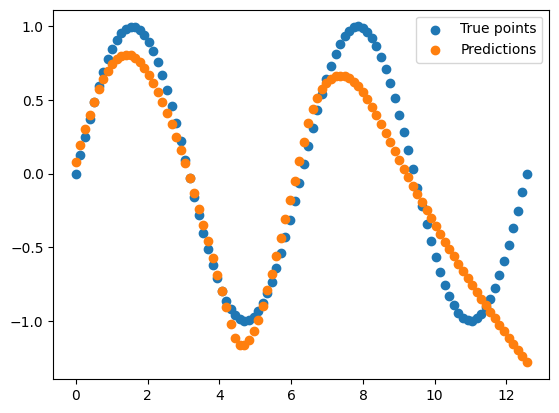

Avg loss: 0.091573 

Epoch: 200


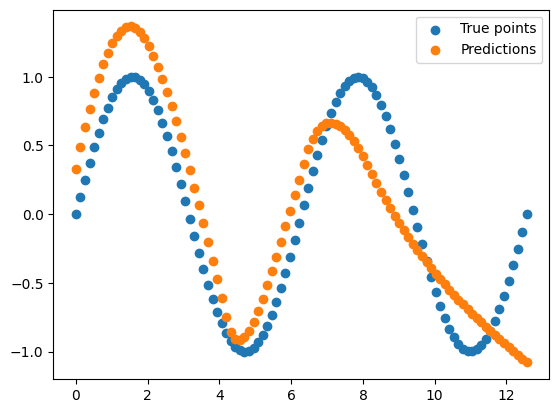

Avg loss: 0.137993 

Done!
Epoch: 1


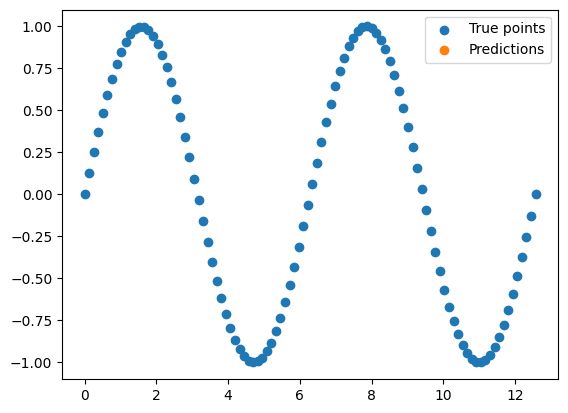

Avg loss:      nan 

Epoch: 2


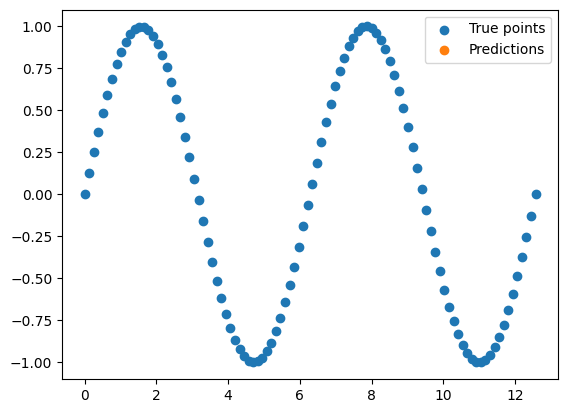

Avg loss:      nan 

Epoch: 3


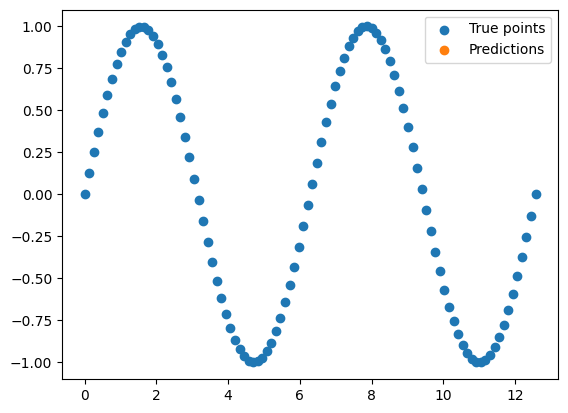

Avg loss:      nan 

Epoch: 4


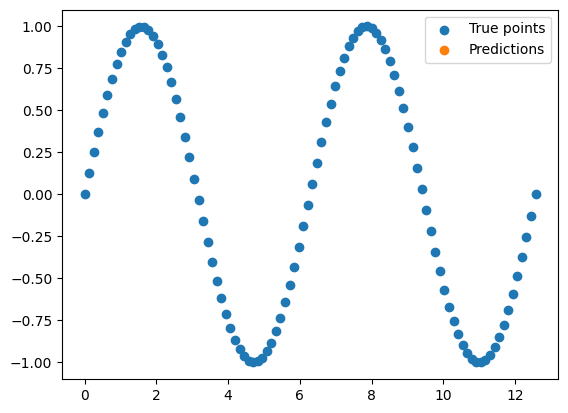

Avg loss:      nan 

Epoch: 5


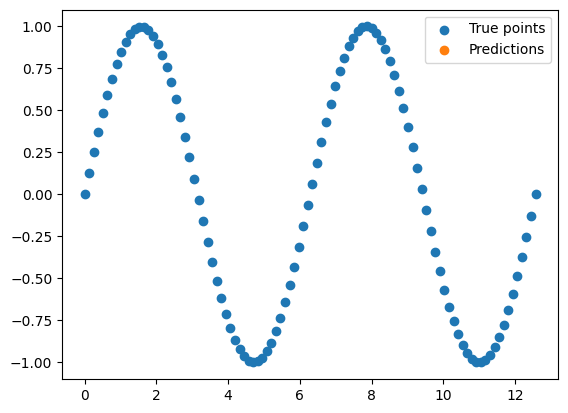

Avg loss:      nan 

Epoch: 6


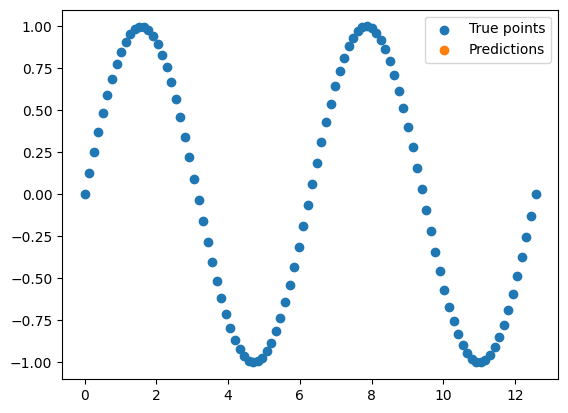

Avg loss:      nan 

Epoch: 7


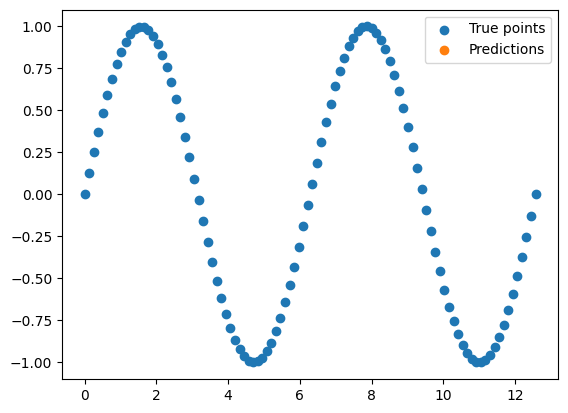

Avg loss:      nan 

Epoch: 8


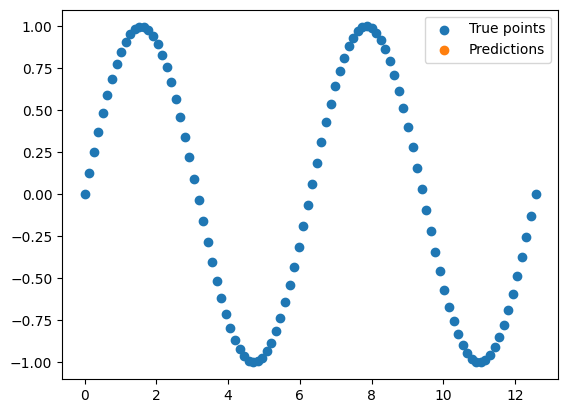

Avg loss:      nan 

Epoch: 9


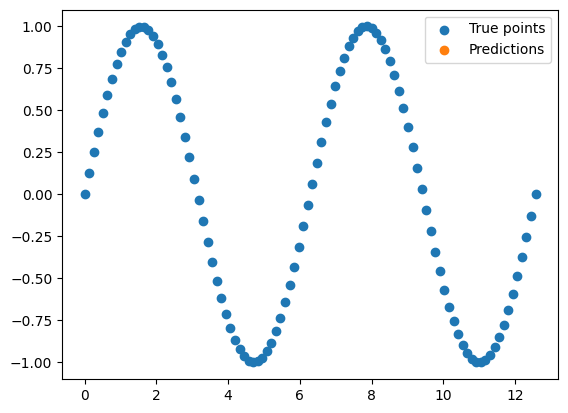

Avg loss:      nan 

Epoch: 10


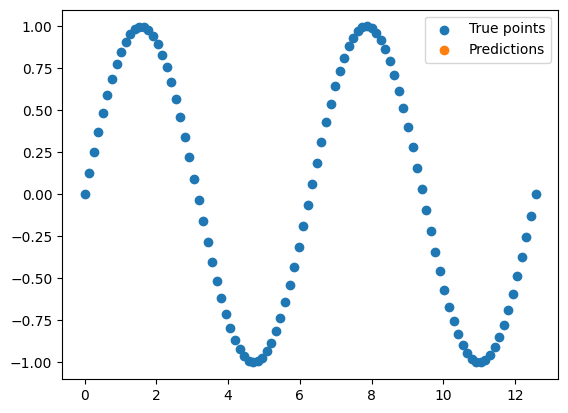

Avg loss:      nan 

Epoch: 11


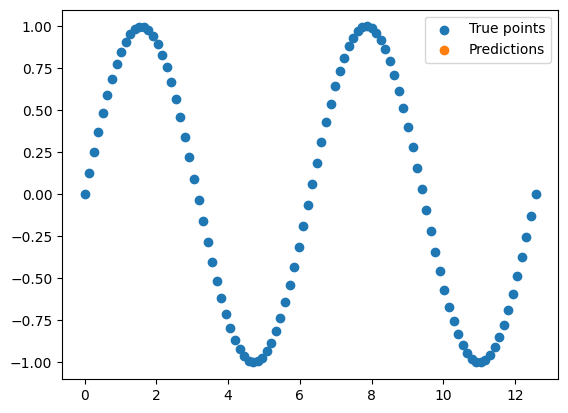

Avg loss:      nan 

Epoch: 12


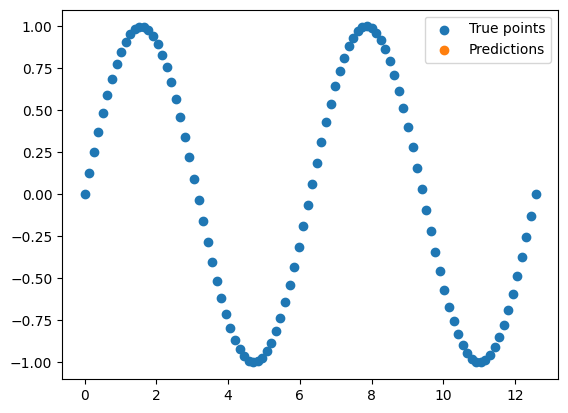

Avg loss:      nan 

Epoch: 13


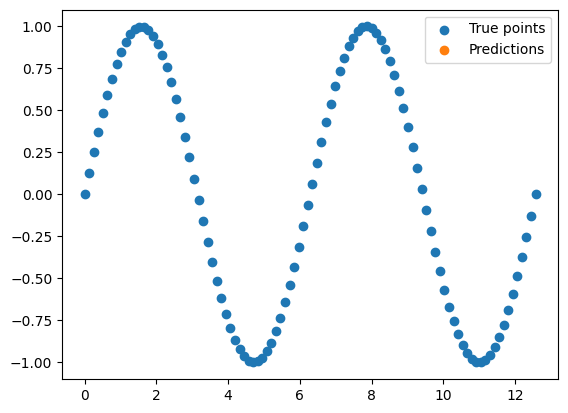

Avg loss:      nan 

Epoch: 14


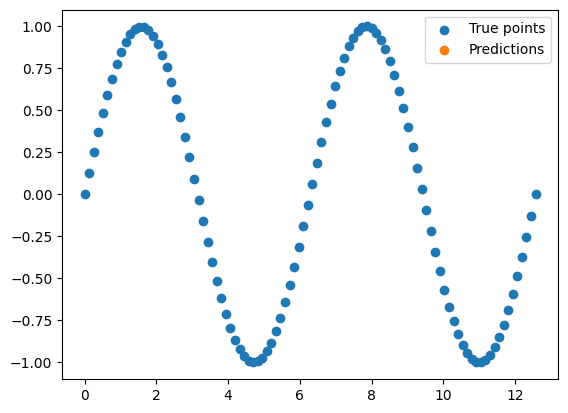

Avg loss:      nan 

Epoch: 15


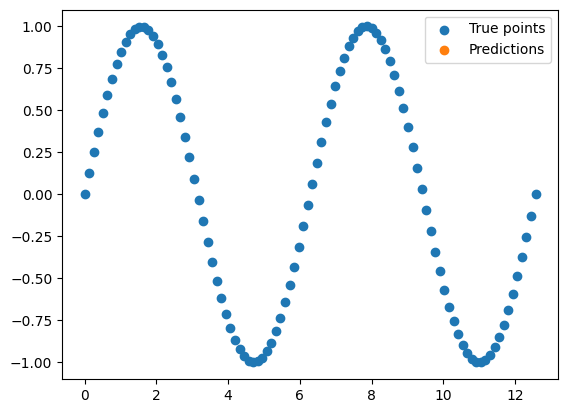

Avg loss:      nan 

Epoch: 40


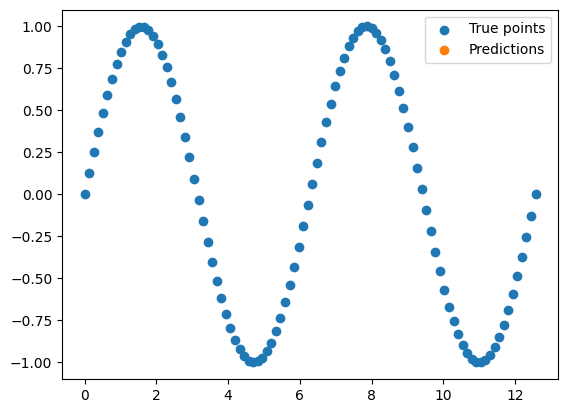

Avg loss:      nan 

Epoch: 80


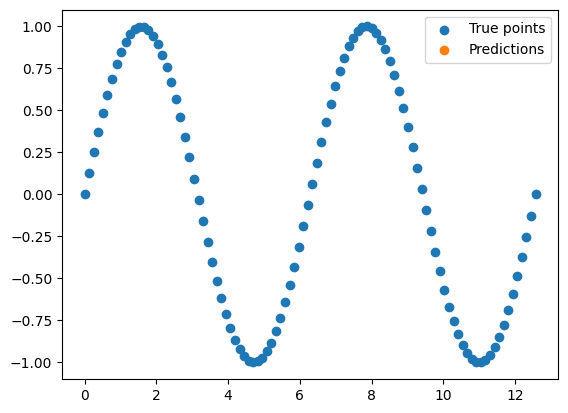

Avg loss:      nan 

Epoch: 120


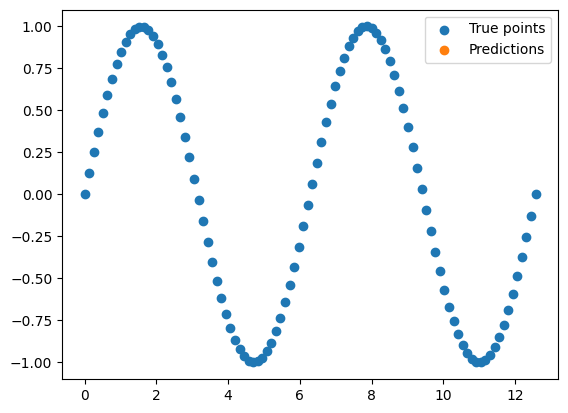

Avg loss:      nan 

Epoch: 160


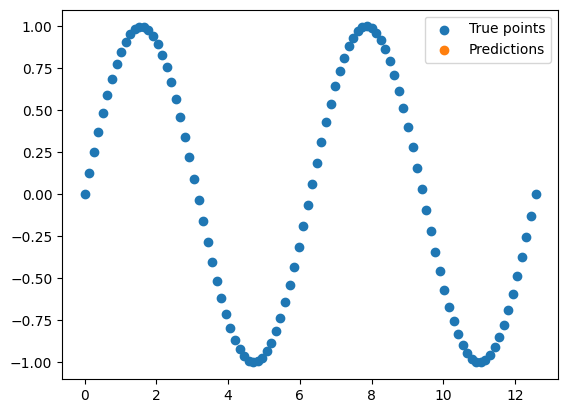

Avg loss:      nan 

Epoch: 200


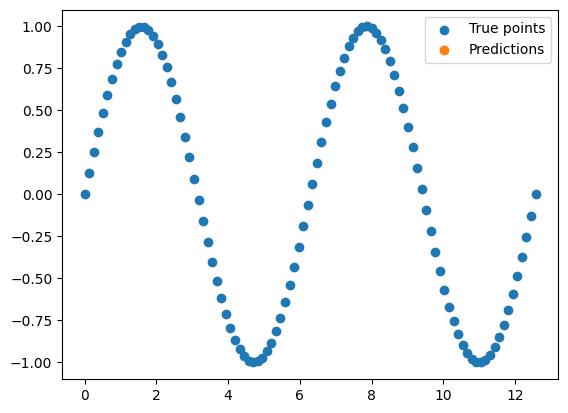

Avg loss:      nan 

Done!
Norm of untrained model: 4.607433470274406
Norm of trained standard model: 6.321909649631886
Norm of trained preconditioned model: nan
Residual from preconditioning: nan
Residual between trained models: nan


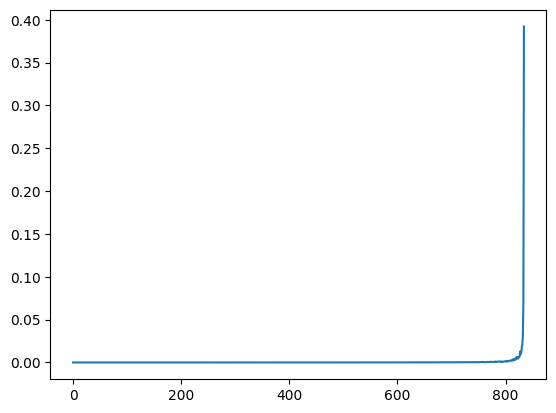

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 40
Epoch: 80
Epoch: 120
Epoch: 160
Epoch: 200
Done!


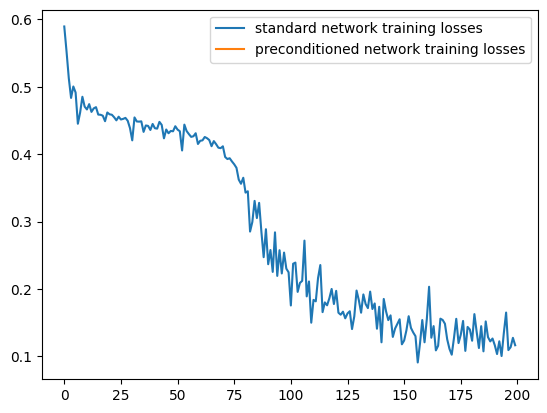

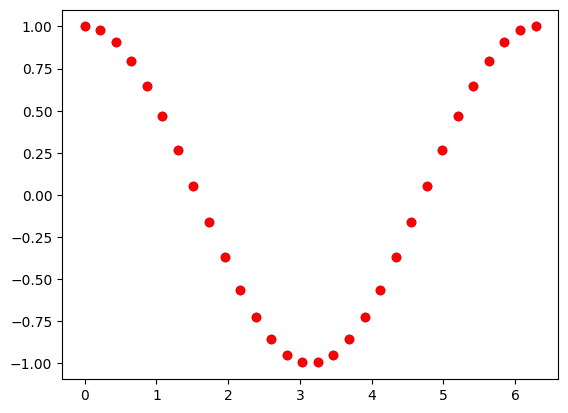

Epoch: 1


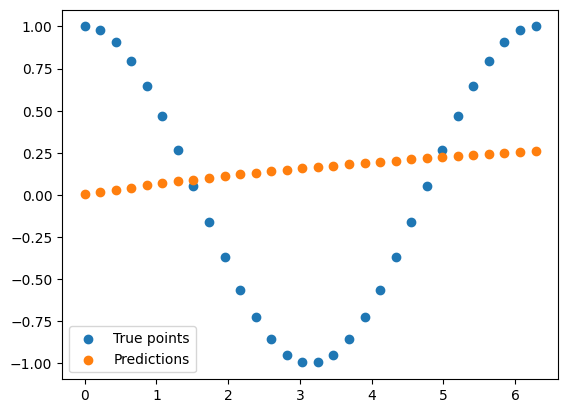

Avg loss: 0.547693 

Epoch: 2


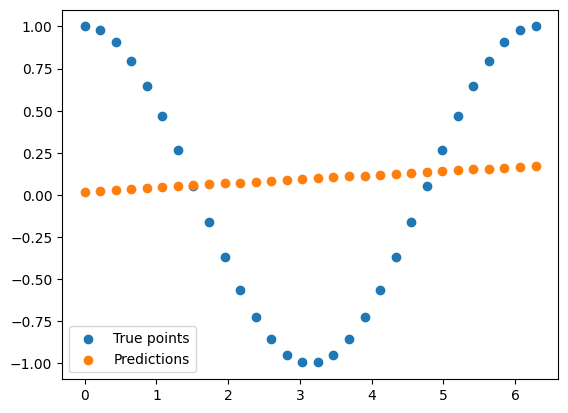

Avg loss: 0.521855 

Epoch: 3


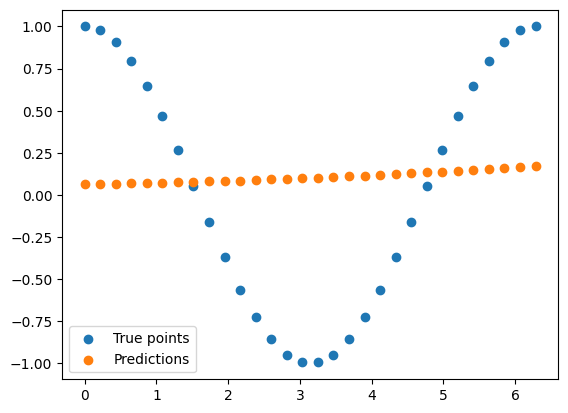

Avg loss: 0.514904 

Epoch: 4


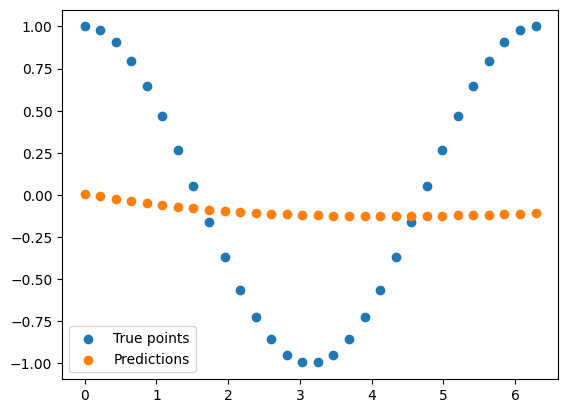

Avg loss: 0.503737 

Epoch: 5


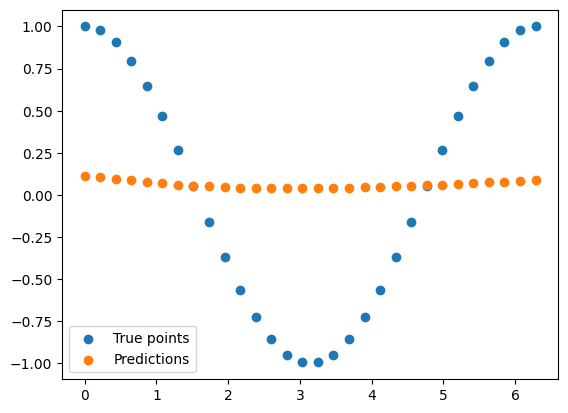

Avg loss: 0.488776 

Epoch: 6


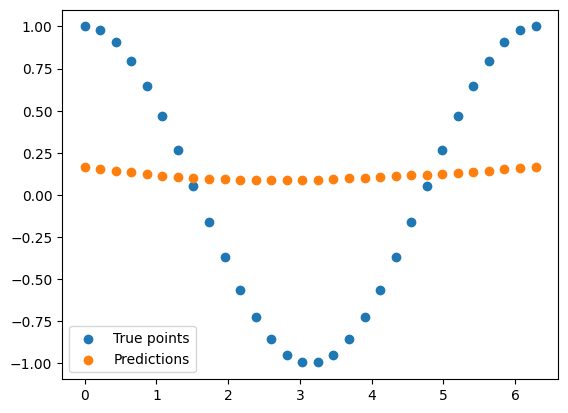

Avg loss: 0.489946 

Epoch: 7


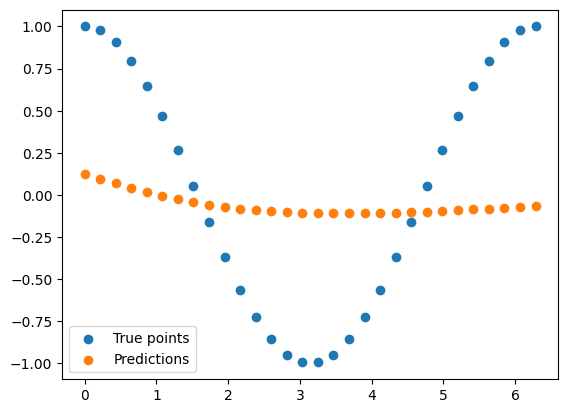

Avg loss: 0.467821 

Epoch: 8


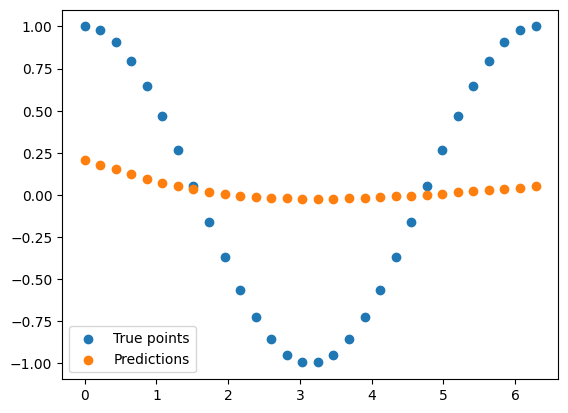

Avg loss: 0.451519 

Epoch: 9


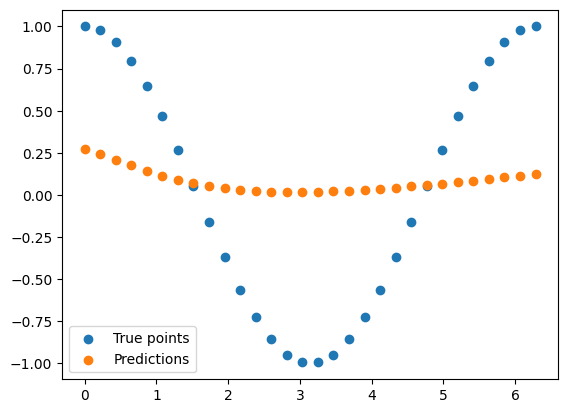

Avg loss: 0.441450 

Epoch: 10


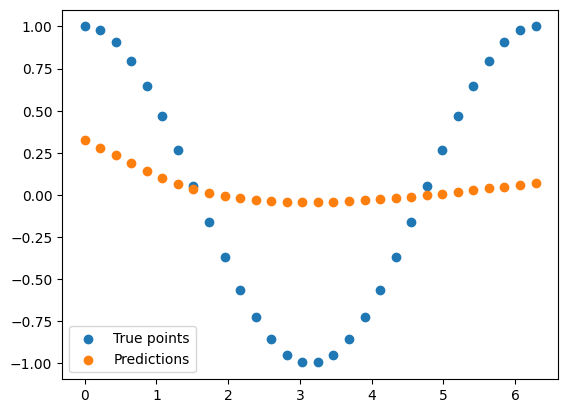

Avg loss: 0.417008 

Epoch: 11


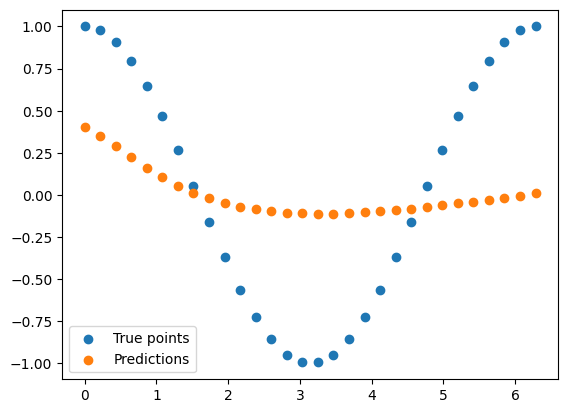

Avg loss: 0.392928 

Epoch: 12


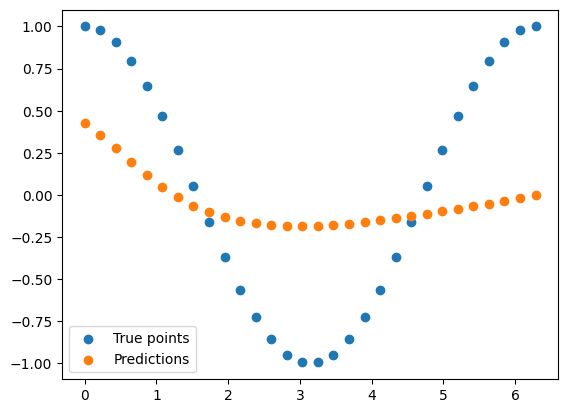

Avg loss: 0.370144 

Epoch: 13


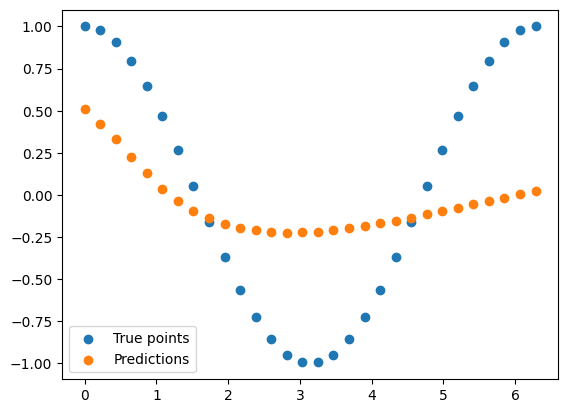

Avg loss: 0.340354 

Epoch: 14


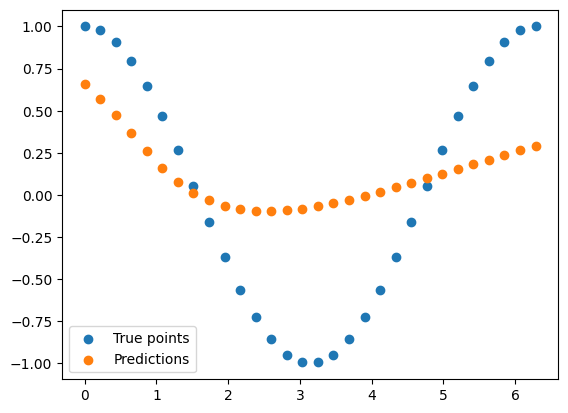

Avg loss: 0.313521 

Epoch: 15


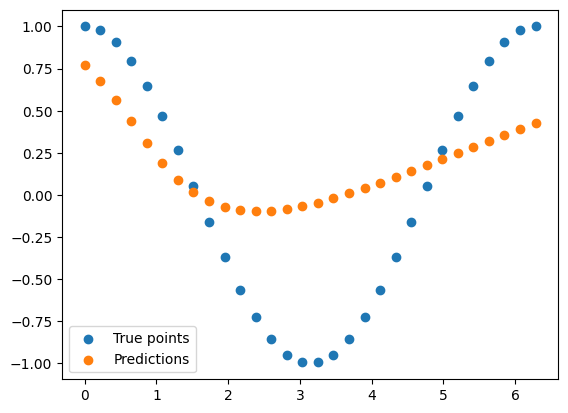

Avg loss: 0.291944 

Epoch: 40


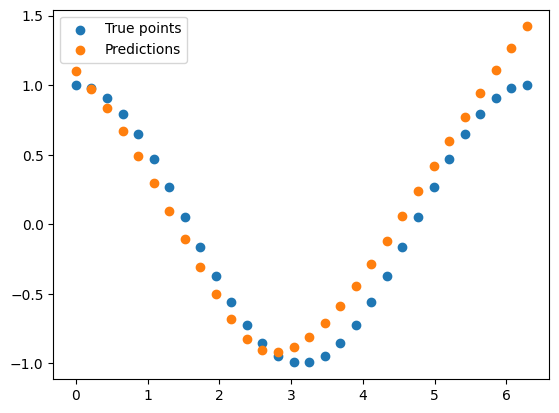

Avg loss: 0.035543 

Epoch: 80


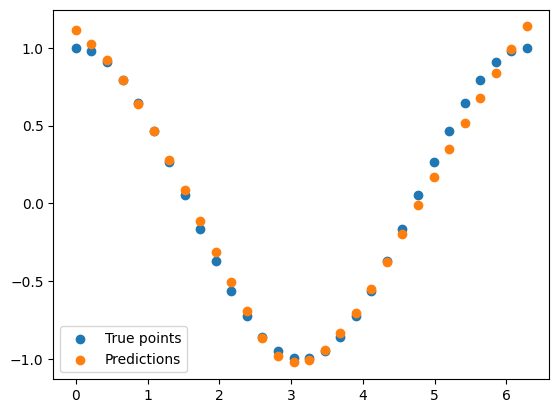

Avg loss: 0.003803 

Epoch: 120


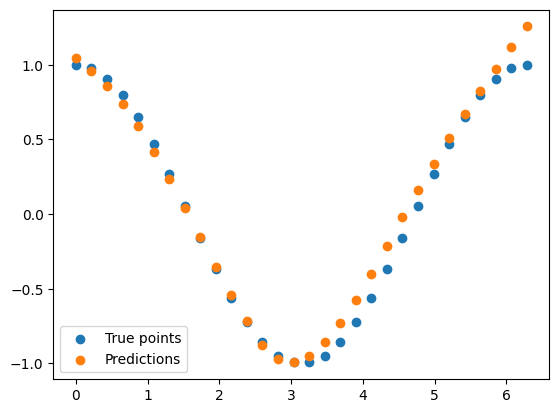

Avg loss: 0.008194 

Epoch: 160


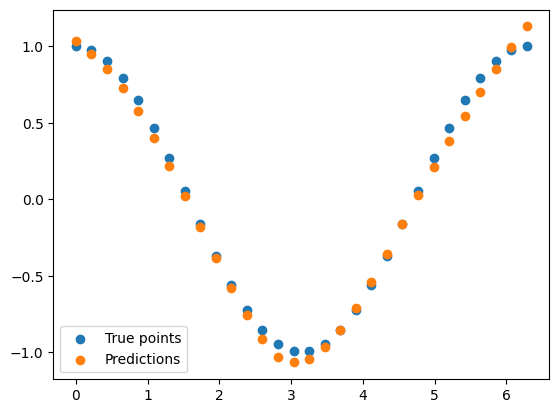

Avg loss: 0.003074 

Epoch: 200


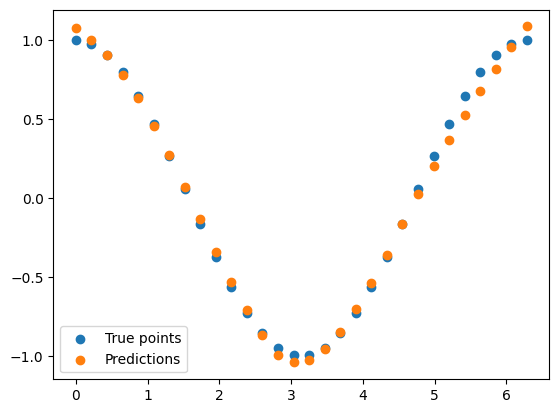

Avg loss: 0.002532 

Done!
Epoch: 1


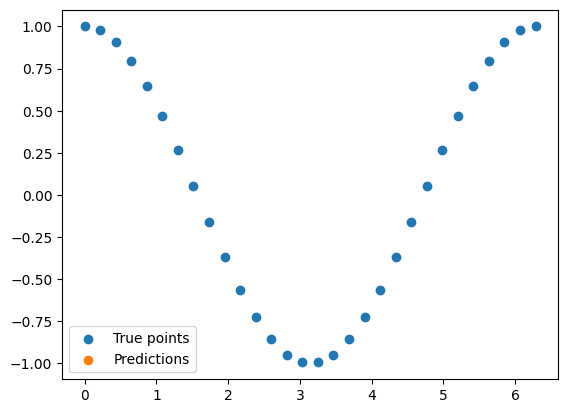

Avg loss:      nan 

Epoch: 2


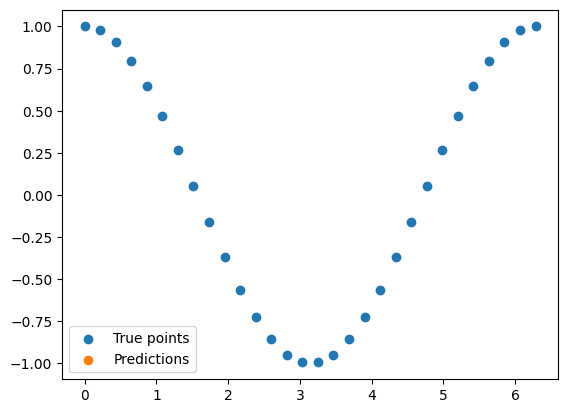

Avg loss:      nan 

Epoch: 3


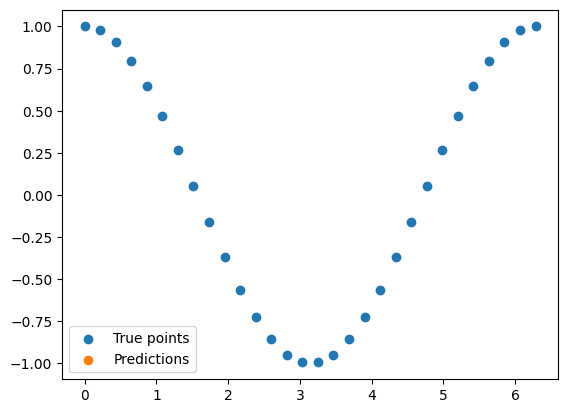

Avg loss:      nan 

Epoch: 4


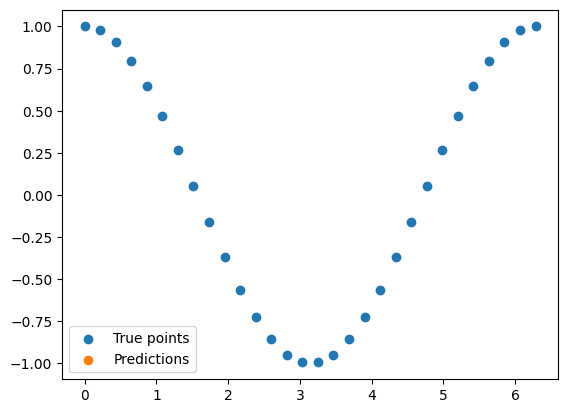

Avg loss:      nan 

Epoch: 5


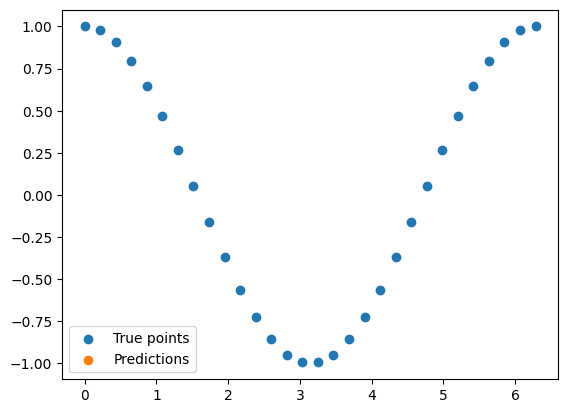

Avg loss:      nan 

Epoch: 6


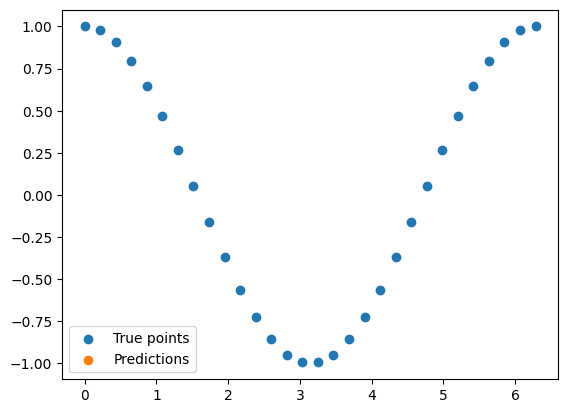

Avg loss:      nan 

Epoch: 7


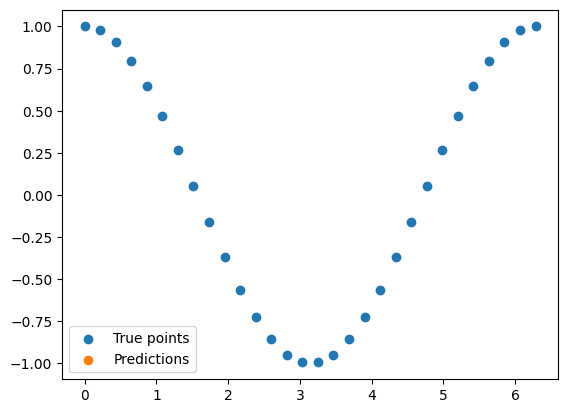

Avg loss:      nan 

Epoch: 8


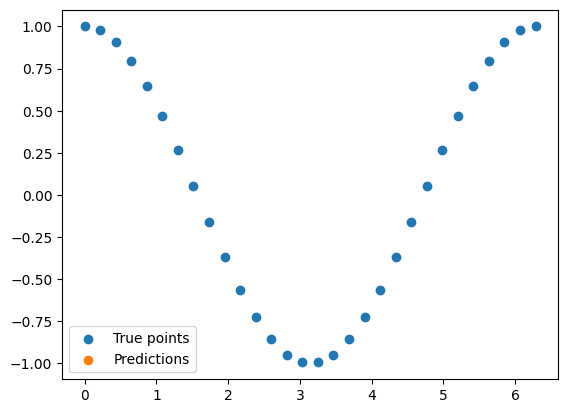

Avg loss:      nan 

Epoch: 9


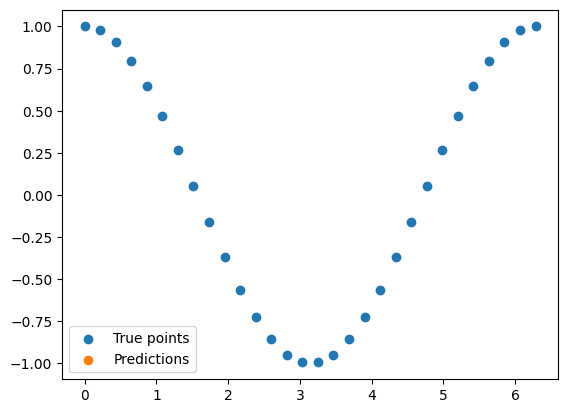

Avg loss:      nan 

Epoch: 10


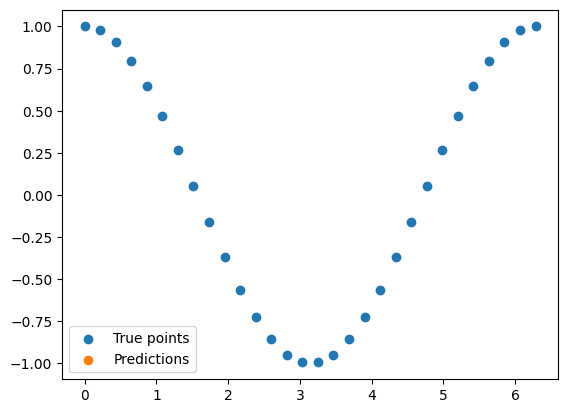

Avg loss:      nan 

Epoch: 11


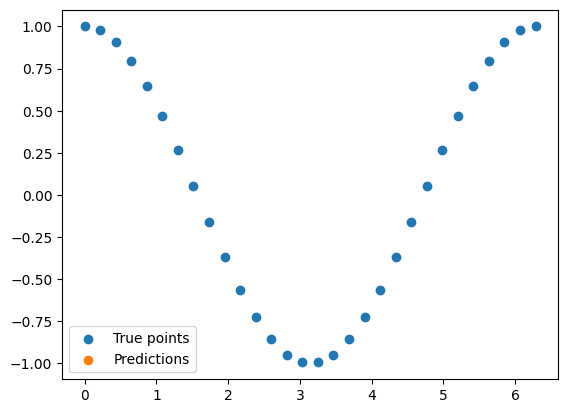

Avg loss:      nan 

Epoch: 12


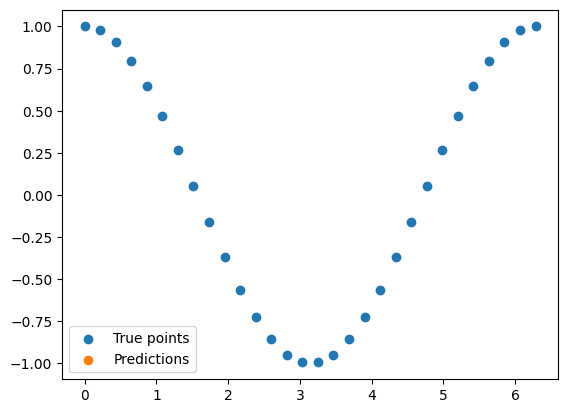

Avg loss:      nan 

Epoch: 13


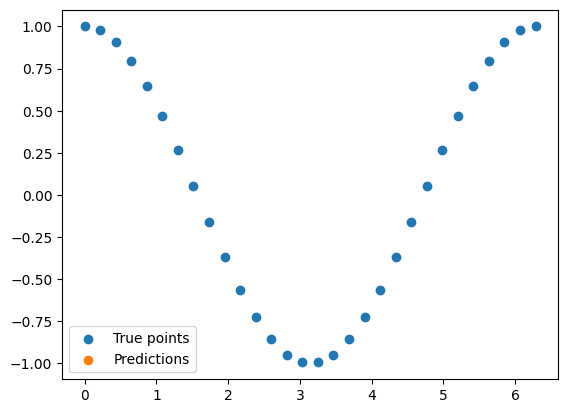

Avg loss:      nan 

Epoch: 14


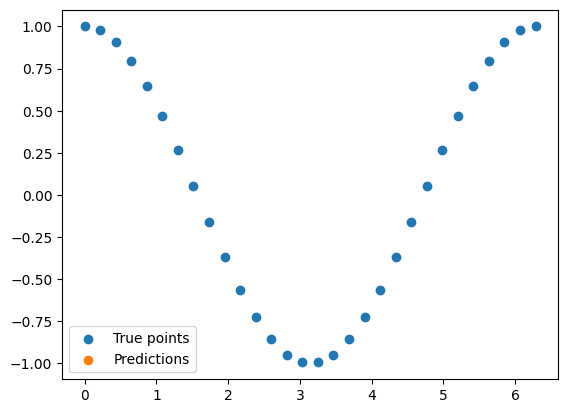

Avg loss:      nan 

Epoch: 15


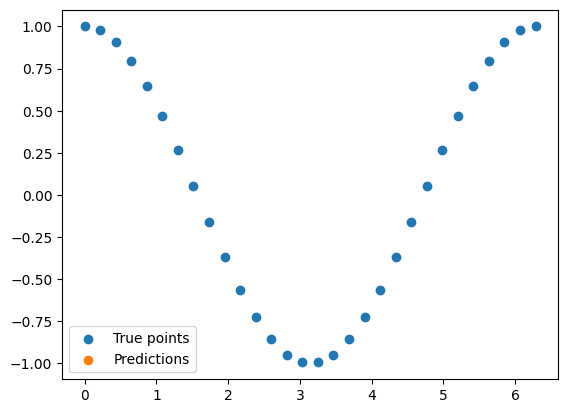

Avg loss:      nan 

Epoch: 40


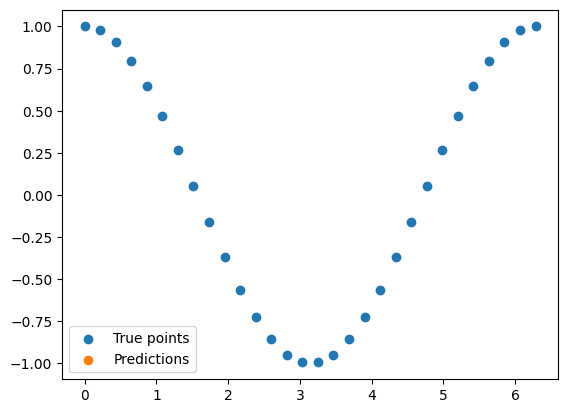

Avg loss:      nan 

Epoch: 80


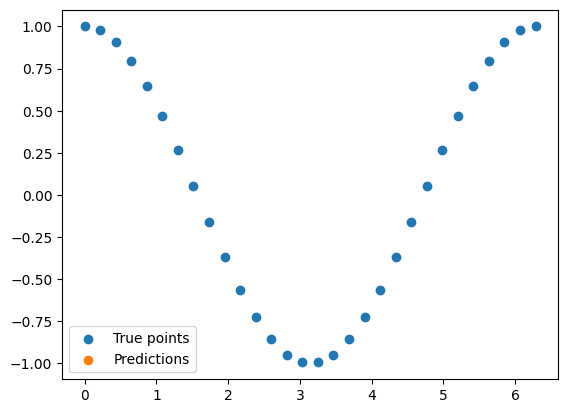

Avg loss:      nan 

Epoch: 120


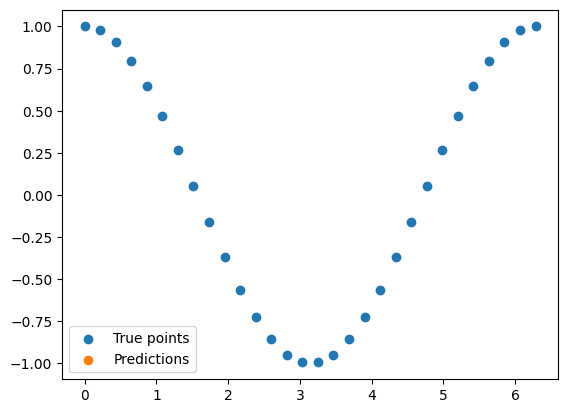

Avg loss:      nan 

Epoch: 160


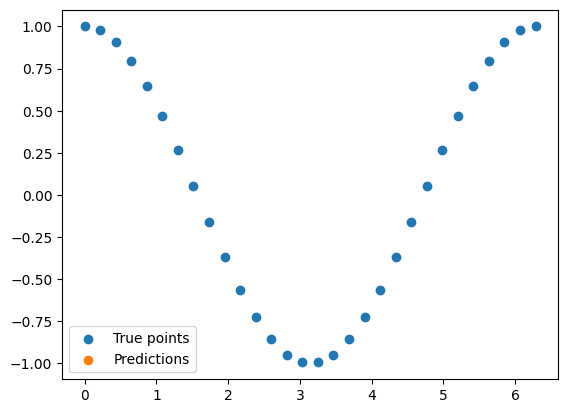

Avg loss:      nan 

Epoch: 200


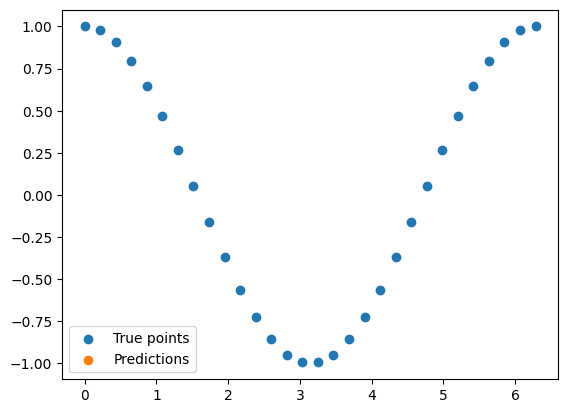

Avg loss:      nan 

Done!


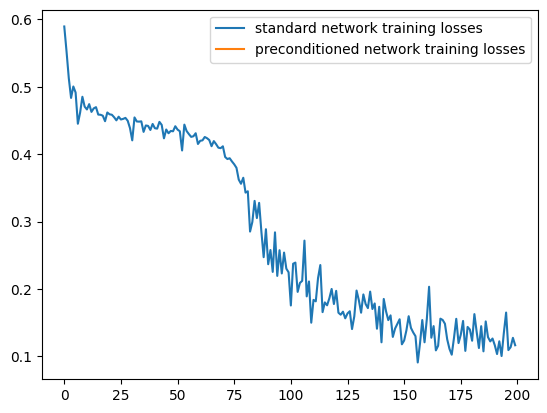

tensor([2.7925])
tensor([4.1888])
tensor([3.4907])
tensor([6.2832])
tensor([1.3963])
tensor([2.0944])
tensor([5.5851])
tensor([0.6981])
tensor([4.8869])
tensor([0.])

tensor([2.7925])
tensor([4.1888])
tensor([3.4907])
tensor([6.2832])
tensor([1.3963])
tensor([2.0944])
tensor([5.5851])
tensor([0.6981])
tensor([4.8869])
tensor([0.])


In [3]:
%run exploration.ipynb

In [26]:
def train_loop_grad_capture(dataloader, model, loss_fn, optimizer, jitter=0):
    size = len(dataloader.dataset)
    total_loss = 0
    batches = 0
    gradients = {}
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X + torch.normal(0, jitter, X.shape))
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()

        for name, param in model.named_parameters():
            if name not in gradients:
                gradients[name] = []
            
            if param.grad is not None:
                gradients[name].append(param.grad.clone())
            else:
                print(name)
        
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        batches += 1
        
    return total_loss / batches, gradients

In [29]:
learning_rate = 1e-2
epochs = 150
train_noise = 0.1

In [30]:
normal_model = TinyModel()

train_dataset = FunctionDataset(torch.sin, 100, stop=2*math.pi, noise=train_noise)
test_dataset = FunctionDataset(torch.sin, 100, stop=2*math.pi, rand_pts=False)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(normal_model.parameters(), lr=learning_rate)

Epoch: 1


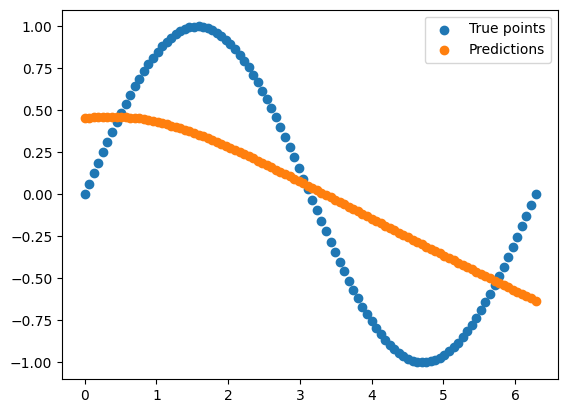

Avg loss: 0.219903 

Epoch: 2


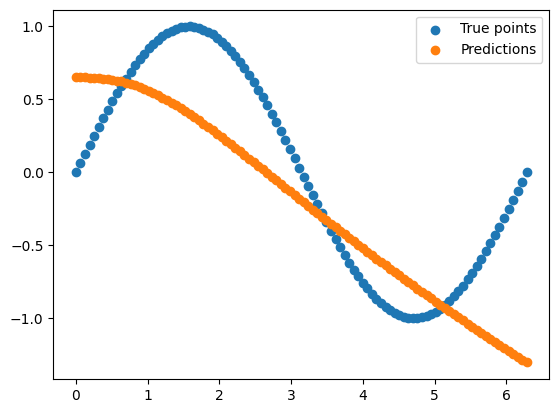

Avg loss: 0.222718 

Epoch: 3


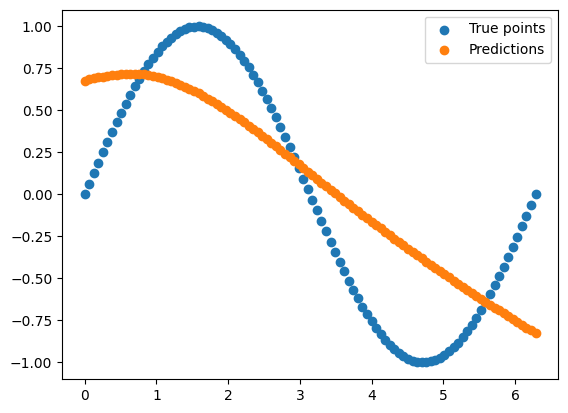

Avg loss: 0.171437 

Epoch: 4


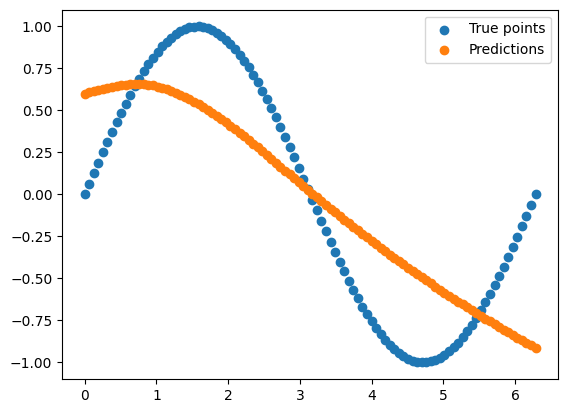

Avg loss: 0.156619 

Epoch: 5


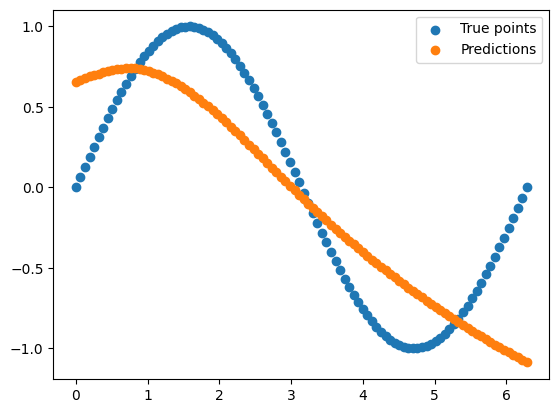

Avg loss: 0.152271 

Epoch: 6


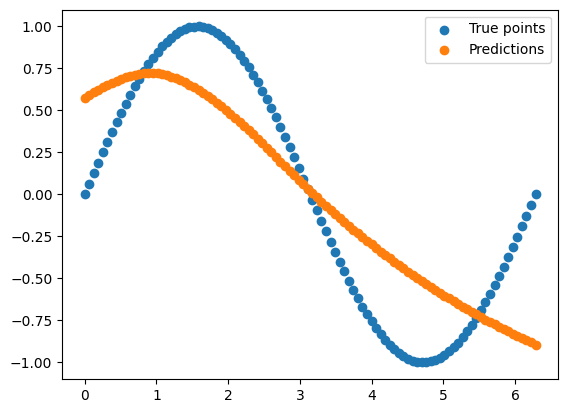

Avg loss: 0.135784 

Epoch: 7


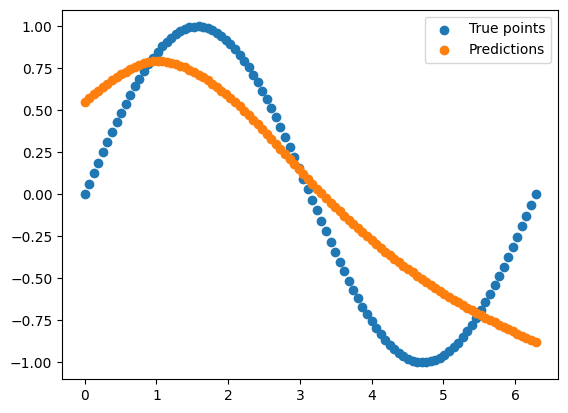

Avg loss: 0.125222 

Epoch: 8


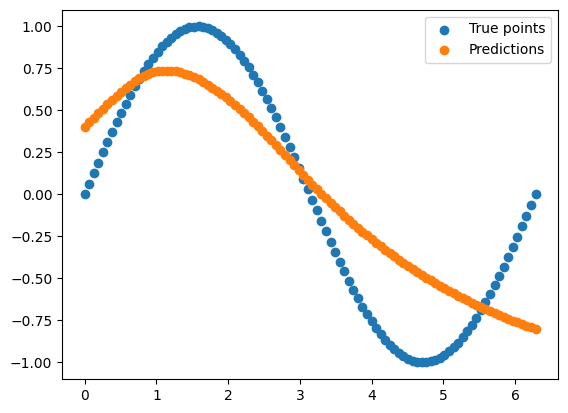

Avg loss: 0.117609 

Epoch: 9


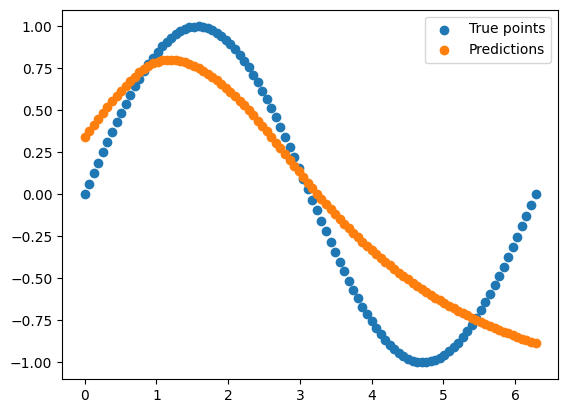

Avg loss: 0.100027 

Epoch: 10


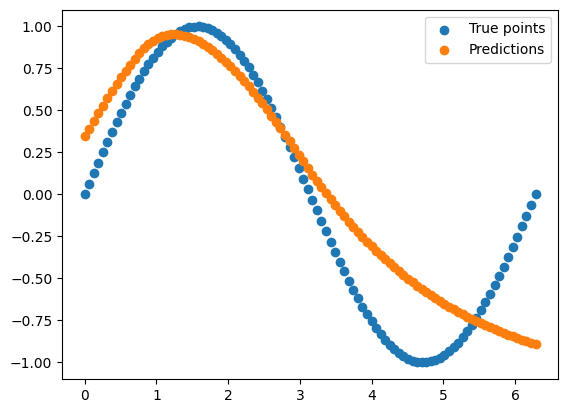

Avg loss: 0.096538 

Epoch: 11


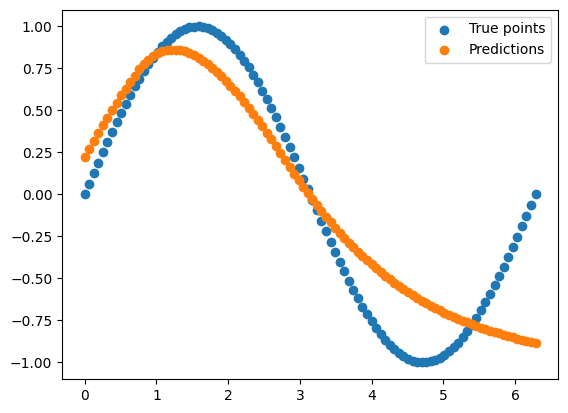

Avg loss: 0.079532 

Epoch: 12


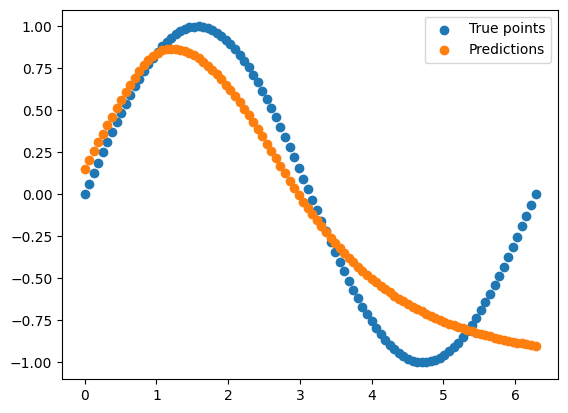

Avg loss: 0.074666 

Epoch: 13


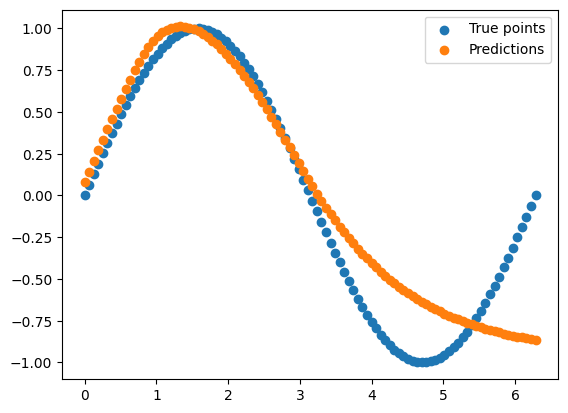

Avg loss: 0.068717 

Epoch: 14


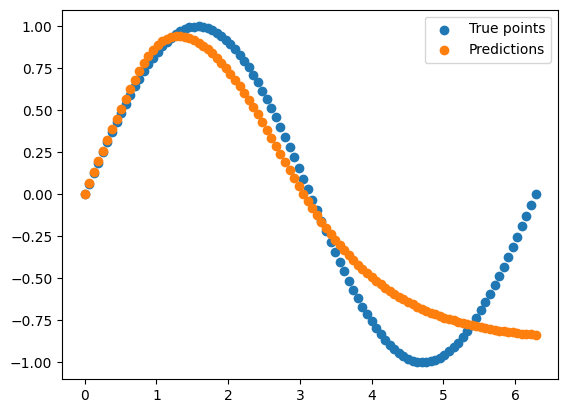

Avg loss: 0.059338 

Epoch: 15


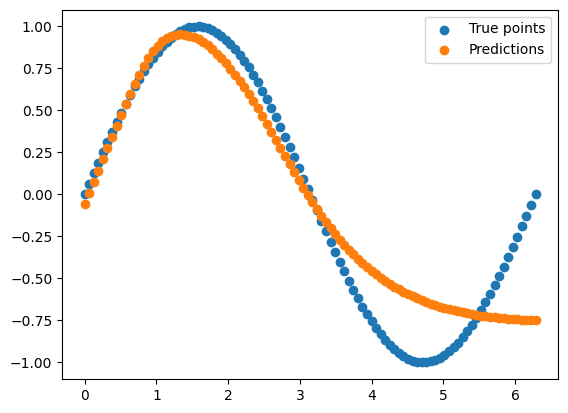

Avg loss: 0.055474 

Epoch: 30


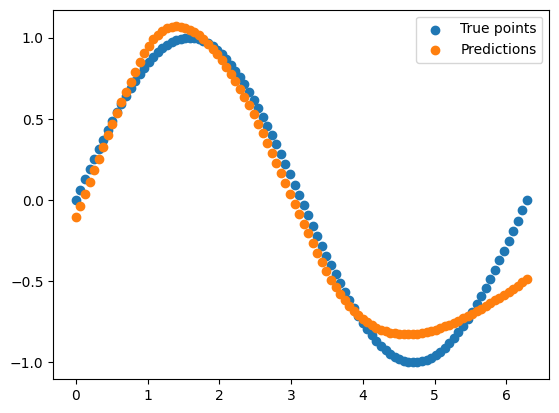

Avg loss: 0.018175 

Epoch: 60


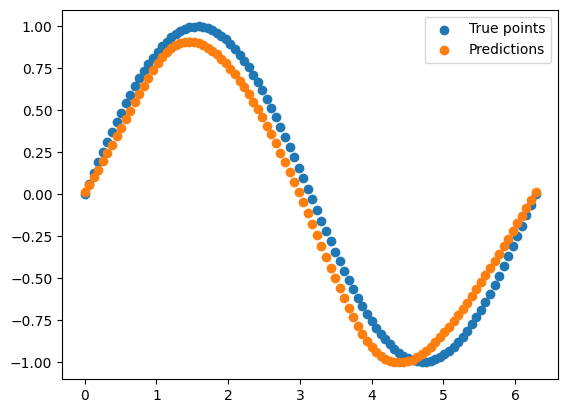

Avg loss: 0.014822 

Epoch: 90


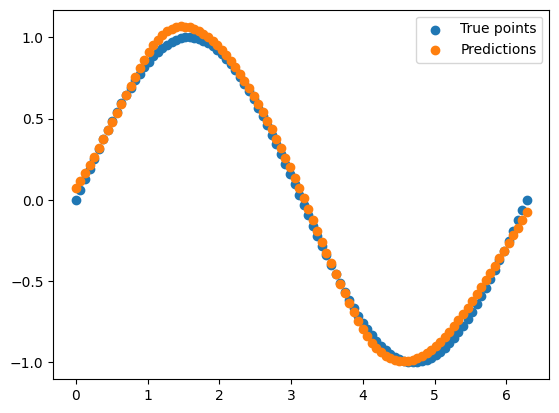

Avg loss: 0.001853 

Epoch: 120


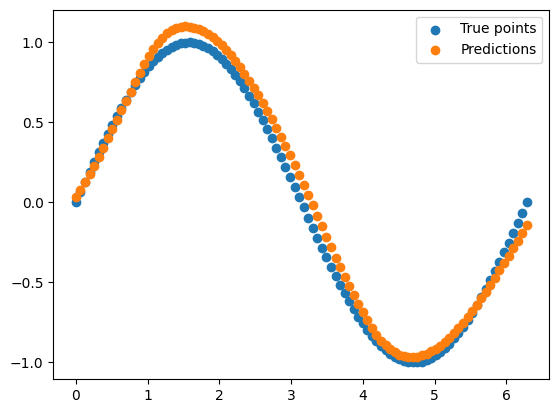

Avg loss: 0.006580 

Epoch: 150


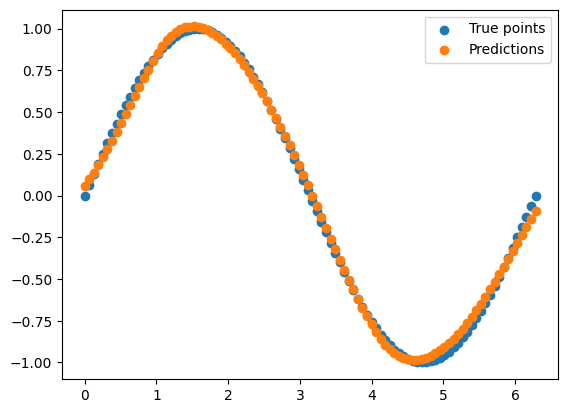

Avg loss: 0.000950 



In [31]:
standard_train_losses = []
grads_per_epoch = []

for t in range(epochs):
    
    avg_loss, gradients = train_loop_grad_capture(train_dataloader, normal_model, loss_function, optimizer)
    standard_train_losses.append(avg_loss)
    grads_per_epoch.append(gradients)
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, normal_model, loss_function)

In [32]:
keys = [x for x in grads_per_epoch[1].keys()]
print(keys)

['layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias', 'layers.4.weight', 'layers.4.bias', 'layers.6.weight', 'layers.6.bias']


In [33]:
def make_grad_lists(grads_per_epoch):
    keys = [x for x in grads_per_epoch[0].keys()]
    combined_grads = {}
    for key in keys:
        combined_grads[key] = []
        
    for i in range(len(grads_per_epoch)):
        for parameter in keys:
            # This concatenation is wrong, they need to be combined along a new, third axis
            # then, later one, we can take the frobenius norm of each set of weights along that third axis
            # i think
            #grads_per_epoch[i][parameter] = torch.linalg.norm(grads_per_epoch[i][parameter])
            combined_grads[parameter].extend(grads_per_epoch[i][parameter])
    return combined_grads


def normed_grad_lists(grad_lists):
    normed_grads = {}
    keys = [x for x in grad_lists.keys()]
    for key in keys:
        normed_grads[key] = []
    for param in keys:
        for gradient in grad_lists[param]:
            normed_grads[param].append(torch.linalg.norm(gradient).item())
    return normed_grads

In [34]:
grad_lists = make_grad_lists(grads_per_epoch)
grad_norm_lists = normed_grad_lists(grad_lists)

In [35]:
keys = [x for x in grad_norm_lists.keys()]
print(keys)
print(len(grad_norm_lists['layers.0.weight']))

['layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias', 'layers.4.weight', 'layers.4.bias', 'layers.6.weight', 'layers.6.bias']
15000


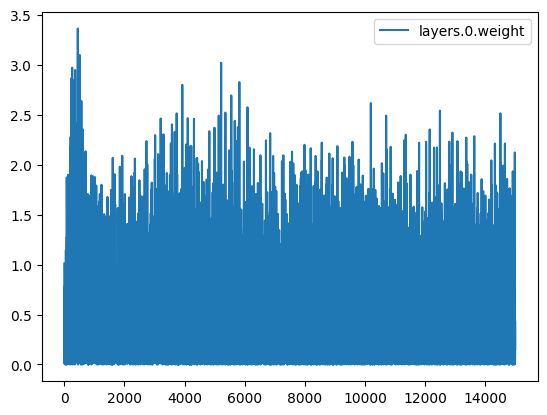

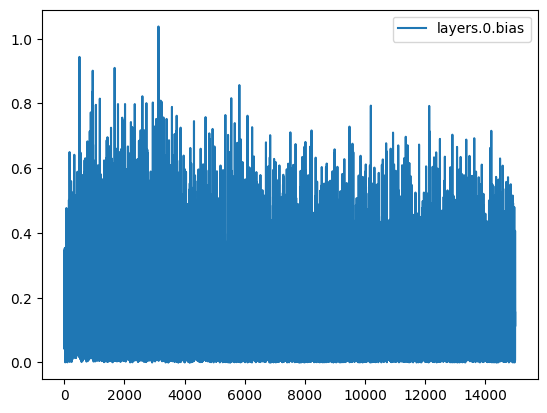

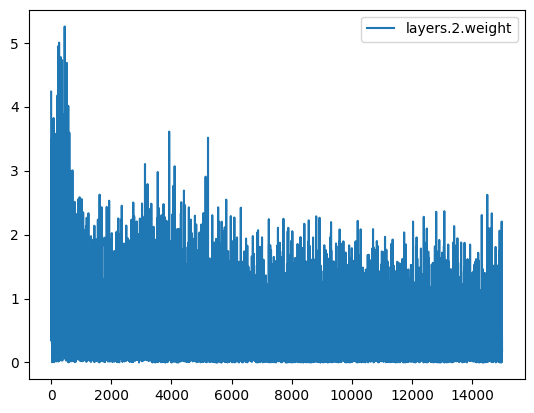

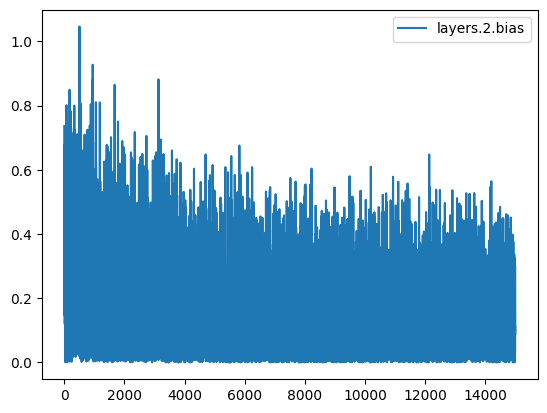

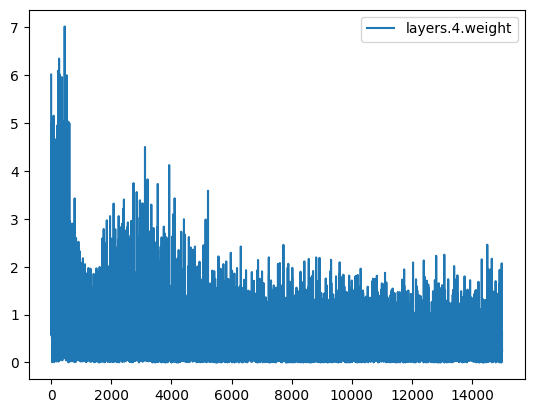

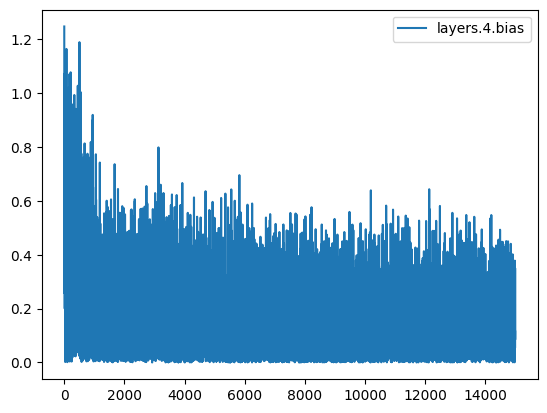

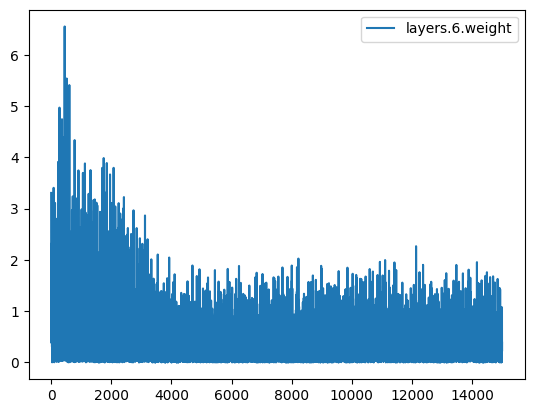

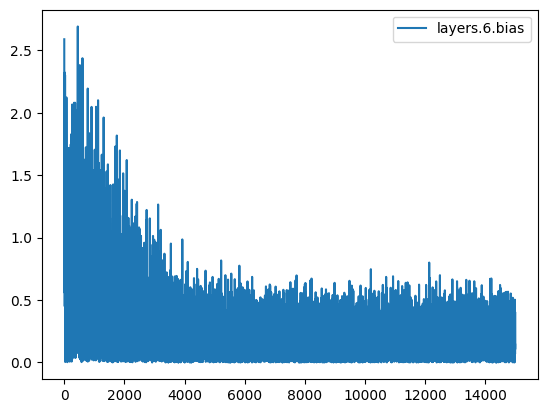

In [36]:
def plot_grad_norms(grad_norm_lists, key):
    num_items =  len(grad_norm_lists[key])
    fig, ax = plt.subplots()
    ax.plot([x for x in range(num_items)], grad_norm_lists[key], label=key)
    ax.legend()

for key in keys:
    plot_grad_norms(grad_norm_lists, key)

In [37]:
grad_series = {}
for key in grad_norm_lists.keys():
    grad_series[key] = pd.Series(grad_norm_lists[key])

for key in grad_series.keys():
    print("parameter: ", key)
    print(grad_series[key].describe())
    print()

parameter:  layers.0.weight
count    15000.000000
mean         0.429166
std          0.436263
min          0.000000
25%          0.101183
50%          0.287752
75%          0.625011
max          3.364676
dtype: float64

parameter:  layers.0.bias
count    1.500000e+04
mean     1.635425e-01
std      1.473242e-01
min      3.011319e-07
25%      4.600140e-02
50%      1.243427e-01
75%      2.377704e-01
max      1.037704e+00
dtype: float64

parameter:  layers.2.weight
count    15000.000000
mean         0.521217
std          0.503287
min          0.000003
25%          0.166276
50%          0.370398
75%          0.721471
max          5.253718
dtype: float64

parameter:  layers.2.bias
count    1.500000e+04
mean     1.493376e-01
std      1.295989e-01
min      6.544396e-07
25%      4.933508e-02
50%      1.150290e-01
75%      2.131656e-01
max      1.046226e+00
dtype: float64

parameter:  layers.4.weight
count    15000.000000
mean         0.569264
std          0.556243
min          0.000006
25%     